In [125]:
from collect_data import *
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTextModel, AutoProcessor, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
raw = get_bids_raw(meg_path, patient[0], session[0], '0')

Reading 0 ... 395999  =      0.000 ...   395.999 secs...


/home/matteoc/spect-to-meg/code/collect_data.py:47: RuntimeWarning: The unit for channel(s) MISC 001, MISC 002, MISC 003, MISC 004, MISC 005, MISC 006, MISC 007, MISC 008, MISC 009, MISC 010, MISC 011, MISC 012, MISC 013, MISC 014, MISC 015, MISC 016, MISC 017, MISC 018, MISC 019, MISC 020, MISC 021, MISC 022, MISC 023, MISC 024, MISC 025, MISC 026, MISC 027, MISC 028, MISC 029, MISC 030, MISC 031, MISC 032 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 6601 samples (6.601 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [3]:
get_epochs = get_epochs(raw, task.get("lw1"), float(lw1[0]))

Adding metadata with 18 columns
180 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 180 events and 3201 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)


In [4]:
print('EPOCH_SHAPE: ', get_epochs.get_data().shape)

EPOCH_SHAPE:  (180, 208, 3201)


In [5]:
wav_list_without_numb = list(task.keys())
print(wav_list_without_numb)

['lw1', 'cable_spool_fort', 'easy_money', 'the_black_willow']


In [6]:
audio_path = os.path.join(meg_path, 'collect_data/audio')
audio_list = os.listdir(audio_path)

In [8]:
# CLIP necessità di immagini con 3 canali RGB ? 
colormap = cm.get_cmap('viridis')
audio_data = []
audio_shape = []
for file_name in audio_list:
    file_path = os.path.join(audio_path, file_name)
    tensor = torch.load(file_path)
    audio_shape.append(tensor.shape[0])
    normalized_spectrogram = (tensor - tensor.min()) / (tensor.max() - tensor.min())
    rgba_image = colormap(normalized_spectrogram.numpy())
    rgb_image = torch.tensor(rgba_image[:, :, :, :3]).permute(0, 3, 1, 2)
    audio_data.append(rgb_image)
audio_tensor = list(torch.cat(audio_data, dim=0))
print(len(audio_tensor))

8561


In [ ]:
# not to run

words_list = []
words_shape = []
for task_name, task_value in task.items():
    print(f"TASK_NAME: {task_name}, TASK_VALUE: {task_value}")
    pieces = []
    if task_name == 'lw1':
        pieces = lw1
    elif task_name == 'cable_spool_fort':
        pieces = cable_spool_fort
    elif task_name == 'easy_money':
        pieces = easy_money
    elif task_name == 'the_black_willow':
        pieces = the_black_willow
    for piece in pieces:
        print(f"PIECE_OF_TASK: {piece}")
        raw = get_bids_raw(meg_path, patient[0], session[0], str(int(task_value)))
        meta = list()
        for annot in raw.annotations:
            d = eval(annot.pop("description"))
            for k, v in annot.items():
                assert k not in d.keys()
                d[k] = v
            meta.append(d)
        meta = pd.DataFrame(meta)
        meta["intercept"] = 1.0
        meta=meta[(meta["kind"]=="word") & (meta["story_uid"]==task_value) & 
                    (meta["sound_id"]==float(piece))]  
        words = meta["word"].to_numpy()
        print('WORDS_SHAPE: ', words.shape)
        words_list.append(words)
        words_shape.append(words.shape[0])

wordres_list = [item for array in words_list for item in array]    

In [9]:
save_words_path = os.path.join(meg_path, 'collect_data/words_audio_encoding.npy')
# np.save(save_words_path, wordres_list)
loaded_list = list(np.load(save_words_path, allow_pickle=True))
print(len(loaded_list))

8561


In [70]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
images = np.array(audio_tensor)
text_inputs = loaded_list

inputs_text = tokenizer(text_inputs, padding=True, return_tensors="pt")
text_features = model.get_text_features(**inputs_text)

inputs_img = processor(images=images, return_tensors="pt")
image_features = model.get_image_features(**inputs_img)

inputs = processor(
    text=text_inputs, images=images, return_tensors="pt", padding=True
)
outputs = model(**inputs)

In [85]:
print(text_features.shape)
print(image_features.shape)
print(outputs['text_embeds'].shape)
print(outputs['image_embeds'].shape)

torch.Size([8561, 512])
torch.Size([8561, 512])
torch.Size([8561, 512])
torch.Size([8561, 512])


In [126]:
model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
inputs_text_mod = tokenizer(text_inputs, padding=True, return_tensors="pt")
outputs_text_mod = model(**inputs_text_mod)
last_hidden_state = outputs_text_mod.last_hidden_state
pooled_output = outputs_text_mod.pooler_output  

In [127]:
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([8561, 6, 512])
torch.Size([8561, 512])


In [166]:
from sklearn.metrics import silhouette_score

embedding_data = pooled_output.detach().numpy()
silhouette_scores = []
for i in range(3, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(embedding_data)
    silhouette_scores.append(silhouette_score(embedding_data, kmeans.labels_))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 3 
print("Optimal number of clusters:", optimal_clusters)


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1

Optimal number of clusters: 3


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


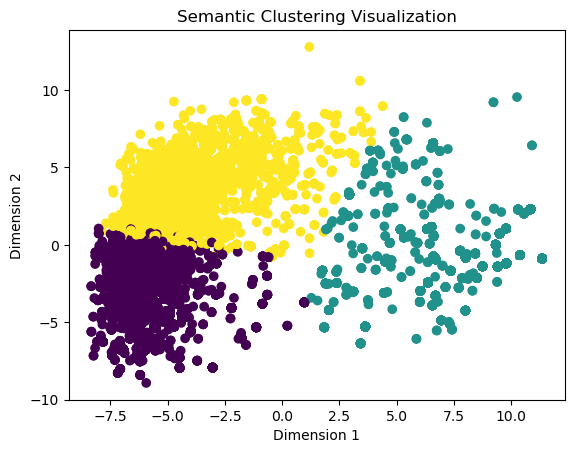

In [179]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embedding_data)
pca = PCA(n_components=2)
reduced_embedding = pca.fit_transform(embedding_data)

plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Semantic Clustering Visualization')
plt.show()



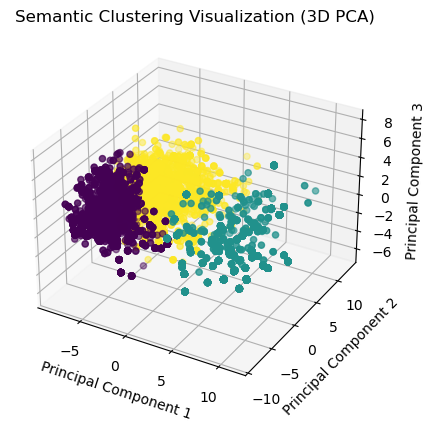

In [180]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
reduced_embedding_3d = pca_3d.fit_transform(embedding_data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_embedding_3d[:, 0], reduced_embedding_3d[:, 1], reduced_embedding_3d[:, 2], c=clusters, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('Semantic Clustering Visualization (3D PCA)')
plt.show()


In [181]:
import pandas as pd

reduced_embedding_list = []
for i in range(reduced_embedding.shape[0]):
    tuple_embdd = tuple(reduced_embedding[i])
    single_dimension_tuple = str(tuple_embdd)
    reduced_embedding_list.append(single_dimension_tuple)
reduced_embedding_arr = np.array(reduced_embedding_list)
print(reduced_embedding_arr.shape)

data = {'Text': text_inputs, 'Embdd': reduced_embedding_arr, 'Cluster': clusters}
df = pd.DataFrame(data)
print(df.head())



(8561,)
      Text                     Embdd  Cluster
0     Tara    (6.8343835, 3.8805704)        1
1    stood   (-2.6188128, 3.9689448)        2
2    stock    (-4.845976, 1.3050879)        2
3    still  (-7.0982046, -3.1905847)        0
4  waiting   (-6.4322443, 1.1698556)        2


In [182]:
cluster_0_texts = df[df['Cluster'] == 0]['Text'].tolist()
print(cluster_0_texts)

['still', 'first', 'from', 'constant', 'recycled', 'from', 'blew', 'annoying', 'but', 'ignored', 'from', 'psychic', 'broke', 'turned', 'annoyance', 'that', 'contemplated', 'gift', 'getting', 'news', 'first', 'slowly', 'replace', 'says', 'contemplated', 'slowly', 'broke', 'Thriving', 'with', 'life', 'kind', 'excellent', 'onto', 'only', 'says', 'should', 'come', 'immediately', 'reported', 'that', 'good', 'nothing', 'here', 'fire', 'come', 'with', 'from', 'decisions', 'what', 'using', 'returned', 'regarding', 'own', 'typical', 'style', 'right', 'hours', 'full', 'with', 'look', 'every', 'ever', 'full', 'than', 'even', 'first', 'than', 'blew', 'prepare', 'completed', 'effect', 'snorted', 'look', 'like', 'hell', 'this', 'let', 'discretion', 'from', 'watched', 'shaking', 'with', 'seemed', 'but', 'having', 'that', 'incredible', 'gift', 'There', 'more', 'Well', 'that', 'would', 'project', 'would', 'shame', 'lose', 'that', 'talent', 'though', 'first', 'psychic', 'which', 'this', 'discretion', 'w